In [1]:
import sys
import os
import random
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim

In [2]:
# Function to Preprocess Data

TRAIN_DATA = '../data/train.jsonl'
TEST_DATA = '../data/test.jsonl'
INPUT_DIR = Path('../data')
OUTPUT_DIR = Path('../data/output/')

def PreprocessData(method='response only'):
  '''
  The method argument can take these possible values:
    'response only' = only use response for fitting model
    'context only' = only use context for fitting model
    'response + context' = concatenate response to context
    'context + response' = concatenate context to response
  '''

  # Read In Train
  df = pd.read_json(INPUT_DIR / 'train.jsonl', lines=True, encoding = sys.getdefaultencoding())

  # Read In Data For Submission
  df_sub = pd.read_json(INPUT_DIR / 'test.jsonl', lines=True, encoding = sys.getdefaultencoding())

  # Convert Lables to Integers
  df['label'] = (df['label'] == 'SARCASM').astype('int')

  # Prepare text Column Based on Method
  if method == 'response only':
    # Training
    df['text'] = df['response']
    # Submission
    df_sub['text'] = df_sub['response']
  
  if method == 'context only':
    # Training - Concatenate All List Strings in Context Column
    df['text'] = df['context'].str.join("") 
    # Submission - Concatenate All List Strings in Context Column
    df_sub['text'] = df_sub['context'].str.join("") 

  if method == 'response + context':
    # Training - Concatenate All List Strings in Context Column
    df['context'] = df['context'].str.join("")
    # Submission - Concatenate All List Strings in Context Column
    df_sub['context'] = df_sub['context'].str.join("")

    # Training - Concatenate Respons and Context
    df['text'] = df['response'] + df['context']
    # Submission - Concatenate Respons and Context
    df_sub['text'] = df_sub['response'] + df_sub['context']

  if method == 'context + response':
    # Training - Concatenate All List Strings in Context Column
    df['context'] = df['context'].str.join("")
    # Submission - Concatenate All List Strings in Context Column
    df_sub['context'] = df_sub['context'].str.join("")

    # Training - Concatenate Respons and Context
    df['text'] = df['context'] + df['response'] 
     # Submission - Concatenate Respons and Context
    df_sub['text'] = df_sub['context'] + df_sub['response'] 
    

  # Add Bunk Label For Submission
  df_sub['id'] = 1
  df_sub = df_sub.rename(columns={"id": "label"})

  # Create Dataframes with Only Label and Text Columns
  df_processed = df[['label','text']]
  df_sub_processed = df_sub[['label','text']]

  # Print Dataframe
  print(df_processed.head())

  # Split into Train and Validate
  df_train, df_validate = train_test_split(df, test_size=0.1, random_state=42)

  # Split into Validate and Test
  df_validate, df_test = train_test_split(df_validate, test_size=0.5, random_state=42)

  # Write Train as CSV
  df_train.to_csv(OUTPUT_DIR / 'train.csv', index=False, encoding = sys.getdefaultencoding())  

  # Write Validate as CSV
  df_validate.to_csv(OUTPUT_DIR / 'validate.csv', index=False, encoding = sys.getdefaultencoding())

  # Write Test as CSV
  df_test.to_csv(OUTPUT_DIR / 'test.csv', index=False, encoding = sys.getdefaultencoding())

  # Write Submission as CSV
  df_sub.to_csv(OUTPUT_DIR / 'sub.csv', index=False, encoding = sys.getdefaultencoding())

In [3]:
# Preprocess Data
PreprocessData(method='response only')

   label                                               text
0      1  @USER @USER @USER I don't get this .. obviousl...
1      1  @USER @USER trying to protest about . Talking ...
2      1  @USER @USER @USER He makes an insane about of ...
3      1  @USER @USER Meanwhile Trump won't even release...
4      1  @USER @USER Pretty Sure the Anti-Lincoln Crowd...


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
import torch 
torch.cuda.is_available()

True

In [6]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [7]:
# Model parameter
BATCH_SIZE = 16
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, 
                   include_lengths=False, batch_first=True, fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, unk_token=UNK_INDEX)
#fields = [('context', text_field), ('label', label_field), ('response', text_field)]
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=OUTPUT_DIR, 
                                           train='train.csv', 
                                           validation='validate.csv', 
                                           test='test.csv', 
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), 
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), 
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [8]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        #options_name = "bert-base-uncased"
        options_name = "bert-base-cased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [9]:
# Save and Load Functions
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [10]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = OUTPUT_DIR,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (label, text), _ in train_loader:
            label = label.type(torch.LongTensor)           
            label = label.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, label)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (label, text), _ in valid_loader:
                        
                        label = label.type(torch.LongTensor)           
                        label = label.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, label)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path / 'model.pt', model, best_valid_loss)
                    save_metrics(file_path / 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path / 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [11]:
%%time
# Instantiate 
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=8e-7)

train(model=model, optimizer=optimizer, num_epochs=15)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch [1/15], Step [141/4230], Train Loss: 0.6623, Valid Loss: 0.6349
Model saved to ==> ../data/output/model.pt
Model saved to ==> ../data/output/metrics.pt
Epoch [1/15], Step [282/4230], Train Loss: 0.6362, Valid Loss: 0.7653
Epoch [2/15], Step [423/4230], Train Loss: 0.6442, Valid Loss: 0.6197
Model saved to ==> ../data/output/model.pt
Model saved to ==> ../data/output/metrics.pt
Epoch [2/15], Step [564/4230], Train Loss: 0.6161, Valid Loss: 0.6343
Epoch [3/15], Step [705/4230], Train Loss: 0.6137, Valid Loss: 0.6029
Model saved to ==> ../data/output/model.pt
Model saved to ==> ../data/output/metrics.pt
Epoch [3/15], Step [846/4230], Train Loss: 0.5944, Valid Loss: 0.5734
Model saved to ==> ../data/output/model.pt
Model saved to ==> ../data/output/metrics.pt
Epoch [4/15], Step [987/4230], Train Loss: 0.5986, Valid Loss: 0.5643
Model saved to ==> ../data/output/model.pt
Model saved to ==> ../data/output/metrics.pt
Epoch [4/15], Step [1128/4230], Train Loss: 0.5745, Valid Loss: 0.5504

## Evlauate Model

Model loaded from <== ../data/output/metrics.pt


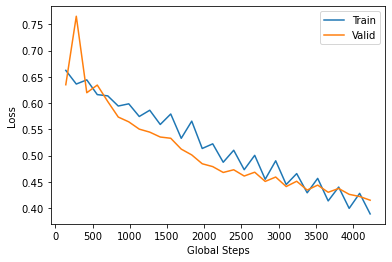

In [12]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(OUTPUT_DIR / 'metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [13]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (label, text), _ in test_loader:

                label = label.type(torch.LongTensor)           
                label = label.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, label)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(label.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['SARCASM', 'NOT_SARCASM'])
    ax.yaxis.set_ticklabels(['SARCASM', 'NOT_SARCASM'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Model loaded from <== ../data/output/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7452    0.8931    0.8125       131
           0     0.8495    0.6639    0.7453       119

    accuracy                         0.7840       250
   macro avg     0.7973    0.7785    0.7789       250
weighted avg     0.7948    0.7840    0.7805       250



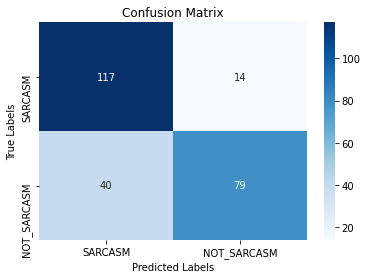

In [14]:
# Instantiate Model
best_model = BERT().to(device)

# Load Best Model Params
load_checkpoint(OUTPUT_DIR / 'model.pt', best_model)

# Get Predictions
evaluate(best_model, test_iter)

## Predictions for Submission

In [ ]:
# Model parameter
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, 
                   batch_first=True, fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, valid, sub = TabularDataset.splits(path=OUTPUT_DIR, 
                                          train='train.csv', 
                                          validation='validate.csv', 
                                          test='sub.csv', 
                                          format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), 
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), 
                            device=device, train=True, sort=True, sort_within_batch=True)
sub_iter = Iterator(sub, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
# Predict Function
def predict(model, sub_loader):
    y_pred = []

    model.eval()
    with torch.no_grad():
        for (label, text), _ in sub_loader:
                label = label.type(torch.LongTensor)           
                label = label.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, label)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())

    return y_pred

In [ ]:
# Instantiate Model
best_model = BERT().to(device)

# Load Best Model Params
load_checkpoint(OUTPUT_DIR / 'model.pt', best_model)

# Get Predictions
y_pred = predict(best_model, sub_iter)

In [ ]:
# Create Lists of IDs and Predictions
id_list = ['twitter_' + str(x) for x in range(1,1801)]
label_list = ['SARCASM' if x == 1 else 'NOT_SARCASM' for x in y_pred] 

In [ ]:
# Create Dataframe for Submission
df_submission = pd.DataFrame(list(zip(id_list, label_list)), columns =['id', 'label']) 

In [ ]:
df_submission.head()

In [ ]:
df_submission.to_csv('../answer.txt', header=False, index=False)